In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_wine
from sklearn.datasets import load_iris
from sklearn.datasets import fetch_openml
from sklearn.metrics import matthews_corrcoef
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_wine, load_iris
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
import csv
import os

In [21]:
datasets = [
    ("Iris", lambda: load_iris()),
    ("WBDC (Breast Cancer Wisconsin Diagnostic)", lambda: fetch_openml(data_id=1510, as_frame=False)),
    ("Spambase", lambda: fetch_openml(name="spambase", version=1, as_frame=False)),
    ("Heart", lambda: fetch_openml(data_id=533, as_frame=False)),
    ("Glass", lambda: fetch_openml(name="glass", version=2, as_frame=False)),
    ("WBC (Breast Cancer Wisconsin Original)", lambda: fetch_openml(data_id=15, as_frame=False)),
    ("Ionosphere", lambda: fetch_openml(name="ionosphere", version=1, as_frame=False)),
    ("Arrhythmia", lambda: fetch_openml(name="arrhythmia", version=1, as_frame=False)),
    ("Multiple Features", lambda: fetch_openml(name="mfeat-factors", version=1, as_frame=False)),
    ("Australian", lambda: fetch_openml(name="australian", as_frame=False)),
    ("German Number (Credit Dataset)", lambda: fetch_openml(name="credit-g", version=1, as_frame=False)),
    ("DNA", lambda: fetch_openml(name="dna", version=1, as_frame=False)),
    ("Wine", lambda: load_wine()),
    ("Vehicle", lambda: fetch_openml(name="vehicle", version=2, as_frame=False)),
    ("Waveform", lambda: fetch_openml(name="waveform-5000", version=2, as_frame=False)),
    ("Zoo", lambda: fetch_openml(name="zoo", version=2, as_frame=False)),
    ("Hillvalley", lambda: fetch_openml(name="hill-valley", version=2, as_frame=False)),
    ("Sonar", lambda: fetch_openml(name="sonar", version=1, as_frame=False)),
    ("Musk 1", lambda: fetch_openml(name="musk", version=1, as_frame=False))
]


In [22]:
class SAGAFS_GA(BaseEstimator, ClassifierMixin):

    def __init__(self, estimator, cv, scoring='accuracy', population_size=20, generations=10, mutation_rate=0.1, crossover_rate=0.5):
        if not hasattr(estimator, 'fit'):
            raise ValueError("Estimator must have a 'fit' method.")
        if not hasattr(cv, 'split'):
            raise ValueError("cv must be a cross-validation splitter (e.g., StratifiedKFold).")
        if scoring not in ['accuracy', 'matthews_corrcoef', 'f1_score']:
            raise ValueError(f"Scoring method '{scoring}' is not valid. Choose 'accuracy', 'matthews_corrcoef', or 'f1_score'.")

        self.estimator = estimator
        self.cv = cv
        self.scoring = scoring
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.fitness_score = None
        self.best_scores_per_gen = []  # Best fitness scores per generation
        self.avg_scores_per_gen = []  # Average fitness scores per generation
        self.best_individual = None  # Store the best individual

    def fit(self, X, y, dataset_name=None, output_dir="results"):
        n_features = X.shape[1]

        # Initialize population: binary vectors where 1 means feature selected and 0 not selected
        population = [np.random.randint(2, size=n_features) for _ in range(self.population_size)]

        for generation in range(self.generations):
            # Calculate fitness for each individual in the population
            fitness_scores = [self.fitness_function(X, y, individual) for individual in population]

            # Best and average fitness of the current generation
            best_fitness = max(fitness_scores)
            avg_fitness = np.mean(fitness_scores)

            self.best_scores_per_gen.append(best_fitness)
            self.avg_scores_per_gen.append(avg_fitness)

            # Sort population based on fitness scores (highest fitness first)
            sorted_population = [x for _, x in sorted(zip(fitness_scores, population), key=lambda item: item[0], reverse=True)]

            # Elitism: Keep the top individuals
            population = sorted_population[:self.population_size // 2]

            # Create next generation through crossover and mutation
            while len(population) < self.population_size:
                parents = random.sample(population, 2)

                # Use Crossover and Mutation from the child classes
                crossover_obj = self.Crossover(self.crossover_rate)
                mutation_obj = self.Mutation(self.mutation_rate)

                child1, child2 = crossover_obj.apply(parents[0], parents[1])

                # Apply mutation
                if random.random() < self.mutation_rate:
                    child1 = mutation_obj.apply(child1)
                if random.random() < self.mutation_rate:
                    child2 = mutation_obj.apply(child2)

                population.append(child1)
                population.append(child2)

        # Select the best individual after all generations
        self.best_individual = max(population, key=lambda individual: self.fitness_function(X, y, individual))
        self.fitness_score = self.fitness_function(X, y, self.best_individual)

        # Save results to a CSV file
        if dataset_name:
            self.save_results(dataset_name, output_dir)

        return self.fitness_score

    def fitness_function(self, X, y, feature_subset):
        selected_features = np.where(feature_subset == 1)[0]

        if selected_features.size == 0:
            return 0  # No features selected, return a poor fitness score

        try:
            # Perform cross-validation using only the selected features
            X_selected = X[:, selected_features]
            scores = cross_val_score(self.estimator, X_selected, y, cv=self.cv, scoring=self.scoring)
        except Exception as e:
            print(f"Error during cross-validation: {e}")
            return 0  # Return a poor fitness score if cross-validation fails

        return np.mean(scores)

    def save_results(self, dataset_name, output_dir):
        # Ensure output directory exists
        os.makedirs(output_dir, exist_ok=True)

        # Save fitness scores to CSV
        csv_file = os.path.join(output_dir, f"{dataset_name}_fitness_scores.csv")
        with open(csv_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Generation", "Best Fitness", "Average Fitness"])
            for gen in range(self.generations):
                writer.writerow([gen + 1, self.best_scores_per_gen[gen], self.avg_scores_per_gen[gen]])

        # Save the best individual
        best_features_file = os.path.join(output_dir, f"{dataset_name}_best_individual.csv")
        with open(best_features_file, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Feature Index", "Selected"])
            for idx, selected in enumerate(self.best_individual):
                writer.writerow([idx, selected])

    def plot_heatmap(self, feature_scores, feature_names):
        if len(feature_scores) != len(feature_names):
            raise ValueError("Feature scores and feature names must have the same length.")

        feature_scores_reshaped = np.array(feature_scores).reshape(1, -1)
        plt.figure(figsize=(10, 1))
        sns.heatmap(feature_scores_reshaped, annot=True, cmap="coolwarm", xticklabels=feature_names, yticklabels=["Score"])
        plt.title("Feature Importance Heatmap")
        plt.show()

    def plot_fitness_over_generations(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, self.generations + 1), self.best_scores_per_gen, marker='o', color='b')
        plt.title("Fitness Score Evolution Over Generations")
        plt.xlabel("Generation")
        plt.ylabel("Best Fitness Score")
        plt.grid(True)
        plt.show()

    def create_feature_names_dict(self, feature_names):
        """
        Create a dictionary of feature names.
        - feature_names: A list of feature names.
        Returns a dictionary where the key is the feature index (1-based)
        and the value is the feature name.
        """
        self.feature_names_dict = {i + 1: str(i + 1) for i in range(feature_names)}
        return self.feature_names_dict

    # Child class for crossover
    class Crossover:
        def __init__(self, crossover_rate):
            self.crossover_rate = crossover_rate

        def apply(self, parent1, parent2):
            """
            Crossover implementation based on the provided diagram.
            """
            n_features = len(parent1)
            o1 = []  # Offspring 1
            o2 = []  # Offspring 2

            # Step (a): Add common feature indices (features that both parents share)
            common_features = np.where((parent1 == parent2) & (parent1 == 1))[0]
            o1.extend(common_features)
            o2.extend(common_features)

            # Step (b): Identify non-shared features
            nC1 = np.where((parent1 == 1) & (parent2 == 0))[0]
            nC2 = np.where((parent2 == 1) & (parent1 == 0))[0]

            # Step (c): Randomly decide which non-shared features to add to which offspring
            for feature in nC1:
                if random.random() <= 0.66:  # As per the diagram, threshold is 0.66
                    o1.append(feature)
                else:
                    o2.append(feature)

            for feature in nC2:
                if random.random() <= 0.33:  # As per the diagram, threshold is 0.33
                    o2.append(feature)
                else:
                    o1.append(feature)

            # Create binary vectors from the selected feature indices
            child1 = np.zeros(n_features)
            child2 = np.zeros(n_features)
            child1[o1] = 1
            child2[o2] = 1
            print("Child1: ", child1, "Using parent1: ", parent1, " and parent2: ", parent2)
            print("Child2: ", child2)

            return child1, child2

    # Child class for mutation
    class Mutation:
        def __init__(self, mutation_rate):
            self.mutation_rate = mutation_rate

        def apply(self, individual):
            """
            Mutation: randomly flip a feature bit in the individual.
            """
            mutation_point = random.randint(0, len(individual) - 1)
            individual[mutation_point] = 1 - individual[mutation_point]  # Flip the bit
            return individual


# Using KNeighborsClassifier on every dataset from above list


Processing dataset: Iris
Child1:  [0. 0. 1. 1.] Using parent1:  [0 0 1 0]  and parent2:  [0 0 0 1]
Child2:  [0. 0. 0. 0.]
Child1:  [1. 0. 0. 1.] Using parent1:  [1 1 0 1]  and parent2:  [0. 0. 0. 0.]
Child2:  [0. 1. 0. 0.]
Child1:  [0. 0. 1. 0.] Using parent1:  [0. 0. 1. 1.]  and parent2:  [0 0 1 0]
Child2:  [0. 0. 1. 1.]
Child1:  [0. 0. 1. 1.] Using parent1:  [0. 0. 1. 1.]  and parent2:  [0. 0. 1. 1.]
Child2:  [0. 0. 1. 1.]
Child1:  [0. 0. 1. 1.] Using parent1:  [0. 0. 1. 1.]  and parent2:  [1 1 0 1]
Child2:  [1. 1. 0. 1.]
Child1:  [0. 0. 1. 1.] Using parent1:  [1 1 1 1]  and parent2:  [0. 0. 1. 1.]
Child2:  [1. 1. 1. 1.]
Child1:  [1. 0. 1. 1.] Using parent1:  [1. 1. 1. 1.]  and parent2:  [0. 0. 1. 1.]
Child2:  [0. 1. 1. 1.]
Child1:  [0. 1. 1. 1.] Using parent1:  [0. 1. 1. 1.]  and parent2:  [1. 0. 1. 1.]
Child2:  [1. 0. 1. 1.]
Child1:  [1. 1. 1. 1.] Using parent1:  [1 1 1 1]  and parent2:  [1. 0. 1. 1.]
Child2:  [1. 0. 1. 1.]
Child1:  [1. 1. 1. 1.] Using parent1:  [1 1 1 1]  and pare

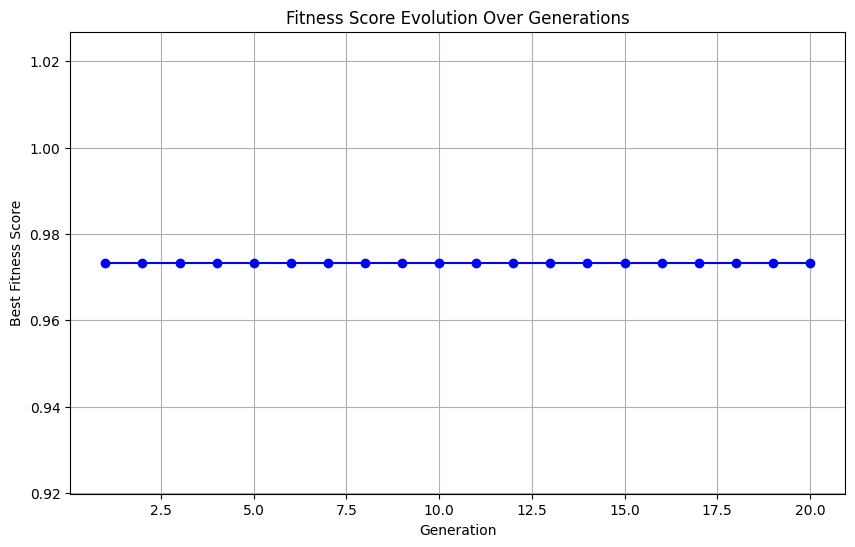

Processing dataset: WBDC (Breast Cancer Wisconsin Diagnostic)
Child1:  [0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 1.] Using parent1:  [0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0]  and parent2:  [0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1]
Child2:  [0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0.]
Child1:  [1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0.
 0. 1. 0. 0. 0. 1.] Using parent1:  [1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0 0 1]  and parent2:  [0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0.]
Child2:  [0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1.
 0. 0. 1. 0. 0. 0.]
Child1:  [0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 1.] Using parent1:  [0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0

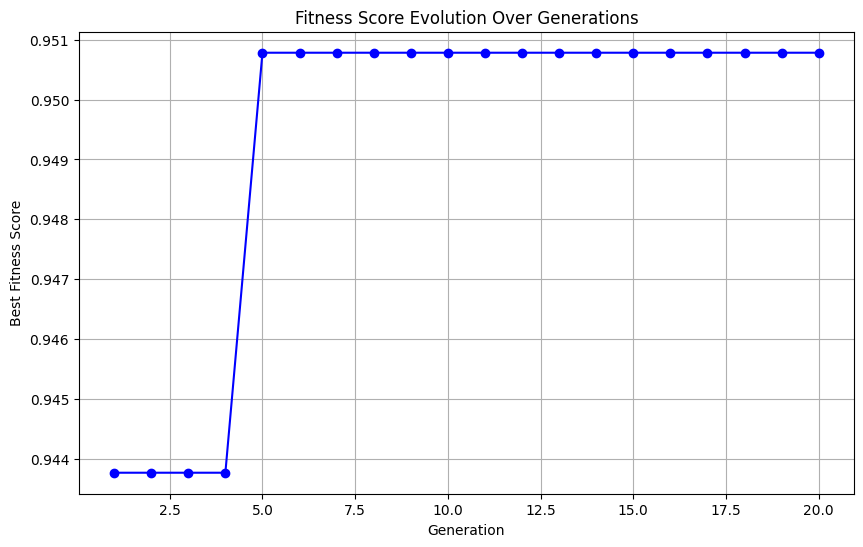

Processing dataset: Spambase
Child1:  [0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 0. 0. 0. 0.] Using parent1:  [0 0 1 0 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0
 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 1 0]  and parent2:  [0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0
 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0]
Child2:  [0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0.
 1. 1. 1. 0. 1. 1. 0. 1. 0.]
Child1:  [1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 1. 0. 1. 0. 1.] Using parent1:  [1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1
 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0]  and parent2:  [0 1 1

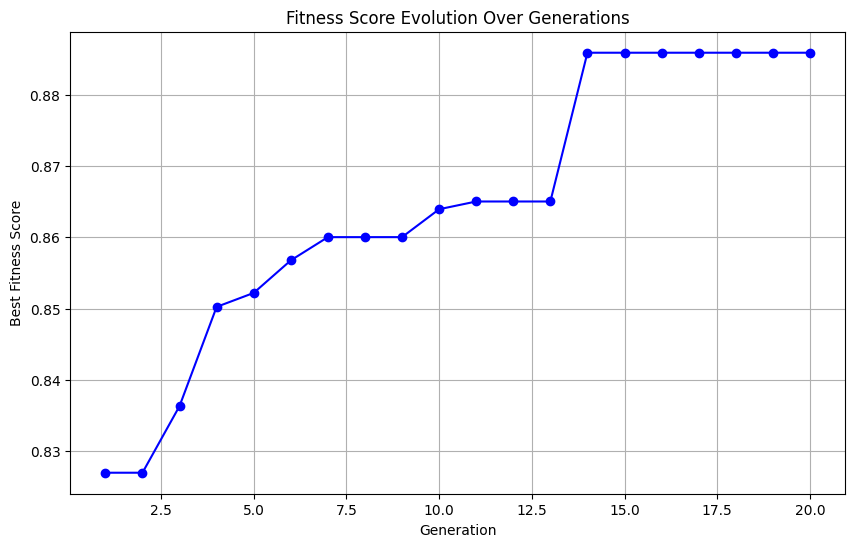

Processing dataset: Heart


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [1. 1. 0. 1.] Using parent1:  [0 0 0 1]  and parent2:  [1 1 0 0]
Child2:  [0. 0. 0. 0.]
Child1:  [1. 0. 1. 1.] Using parent1:  [0. 0. 0. 0.]  and parent2:  [1 0 1 1]
Child2:  [0. 0. 0. 0.]
Child1:  [1. 1. 0. 0.] Using parent1:  [1 1 0 0]  and parent2:  [0 0 0 1]
Child2:  [0. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 1.] Using parent1:  [0 0 0 1]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0 0 0 1]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0 0 0 1]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0 0 0 1]
Child2:  [0. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0 0 0 1]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0 0 0 1]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0 0 0 1]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 1.] Using parent1:  [0 0 0 1]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 0.]
Child2:  [0. 0. 0. 0.]
Child1:  [0. 0. 0. 0.] Using parent1:  [0. 0. 0. 0.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0 0 0 1]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0 0 0 1]
Child2:  [0. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 0.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [1. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [1. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 1.] Using parent1:  [0 0 0 1]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0 0 0 1]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 1.] Using parent1:  [0 0 0 1]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0 0 0 1]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 1.] Using parent1:  [0 0 0 1]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0 0 0 1]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0 0 0 1]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0 0 0 1]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 1.] Using parent1:  [0 0 0 1]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0 0 0 1]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0 0 0 1]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1:  [0. 0. 0. 1.]  and parent2:  [0. 0. 0. 1.]
Child2:  [0. 0. 0. 1.]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Best Fitness Score for Heart: 0.8443693693693695


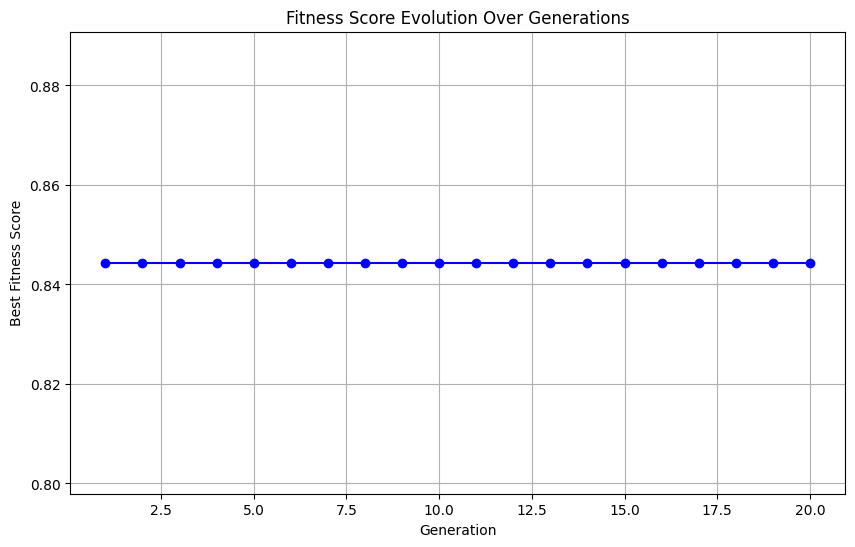

Processing dataset: Glass
Child1:  [0. 0. 1. 0. 1. 1. 1. 1. 0.] Using parent1:  [0 1 1 0 0 1 1 1 0]  and parent2:  [0 0 0 0 1 1 0 1 0]
Child2:  [0. 1. 0. 0. 0. 1. 0. 1. 0.]
Child1:  [0. 1. 0. 0. 0. 1. 1. 1. 0.] Using parent1:  [0. 1. 0. 0. 0. 1. 0. 1. 0.]  and parent2:  [0 1 1 0 0 1 1 1 0]
Child2:  [0. 1. 1. 0. 0. 1. 0. 1. 0.]
Child1:  [0. 0. 1. 1. 1. 1. 0. 0. 1.] Using parent1:  [0. 0. 1. 0. 1. 1. 1. 1. 0.]  and parent2:  [1 0 0 1 1 0 0 0 1]
Child2:  [1. 0. 0. 0. 1. 0. 1. 1. 0.]
Child1:  [0. 0. 1. 1. 1. 1. 1. 0. 1.] Using parent1:  [0. 0. 1. 0. 1. 1. 1. 1. 0.]  and parent2:  [0. 0. 1. 1. 1. 1. 0. 0. 1.]
Child2:  [0. 0. 1. 0. 1. 1. 0. 1. 0.]
Child1:  [0. 0. 1. 1. 0. 1. 1. 1. 1.] Using parent1:  [0 1 1 0 0 1 1 1 0]  and parent2:  [0. 0. 1. 1. 1. 1. 0. 0. 1.]
Child2:  [0. 1. 1. 0. 1. 1. 0. 0. 0.]
Child1:  [0. 0. 1. 0. 1. 1. 0. 1. 0.] Using parent1:  [0. 0. 1. 0. 1. 1. 0. 1. 0.]  and parent2:  [0 1 1 0 0 1 1 1 0]
Child2:  [0. 1. 1. 0. 0. 1. 1. 1. 0.]
Child1:  [0. 0. 1. 1. 0. 0. 1. 1. 1.] 

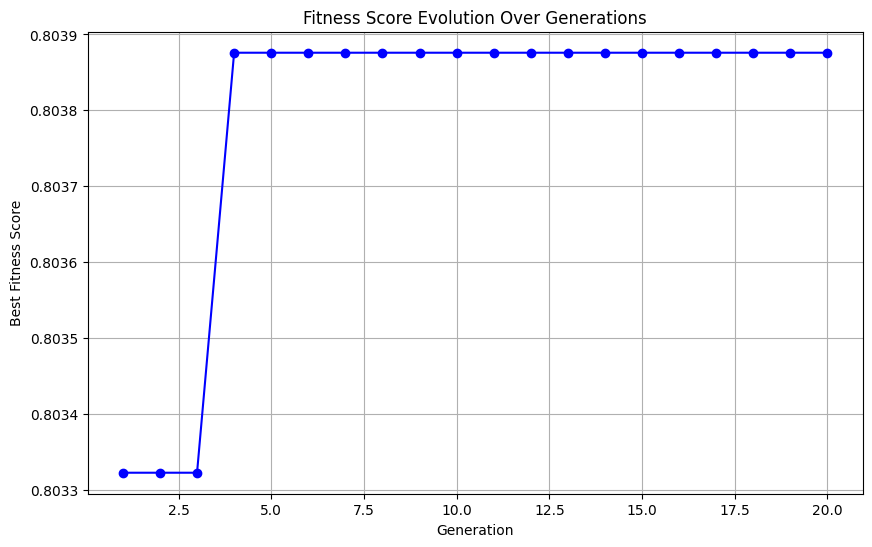

Processing dataset: WBC (Breast Cancer Wisconsin Original)
Error during cross-validation: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 475, in _fit
    X, y = self._validate_data(
  File "

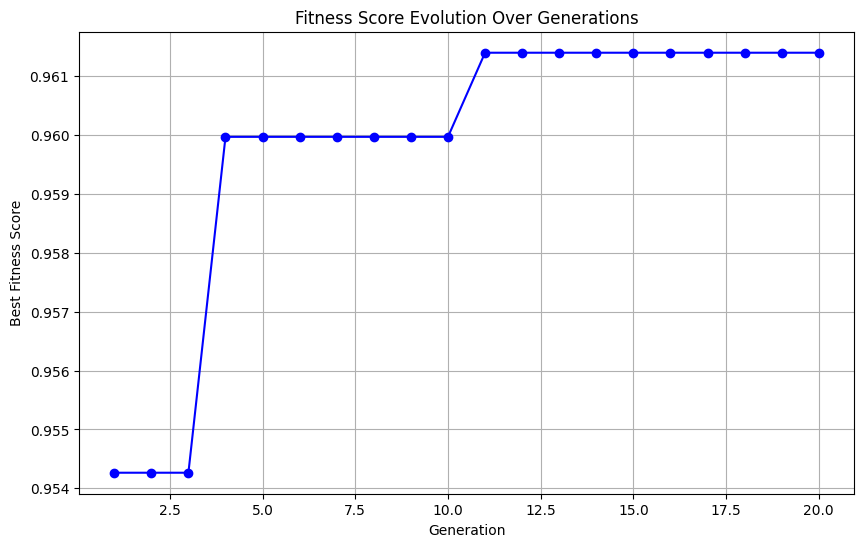

Processing dataset: Ionosphere
Child1:  [1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 1. 0. 0. 1. 1. 0. 1. 1. 1. 1.] Using parent1:  [0 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1 1]  and parent2:  [1 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 1]
Child2:  [0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.]
Child1:  [1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 0. 0. 1. 1.] Using parent1:  [1 0 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1]  and parent2:  [0 1 1 1 1 1 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1]
Child2:  [0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 1. 1. 0. 0. 1. 1. 0. 0. 1. 1.]
Child1:  [1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 0. 0. 0. 1. 1.] Using parent1:  [0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0

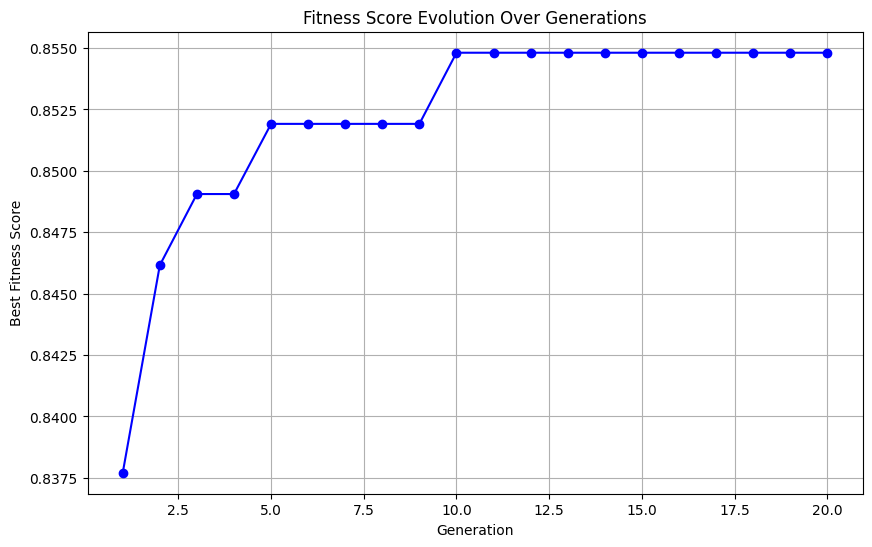

Processing dataset: Arrhythmia
Error during cross-validation: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 475, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/di

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Error during cross-validation: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 475, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", l

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metric

Error during cross-validation: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 475, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", l

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Error during cross-validation: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 475, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", l

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Child1:  [0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1.
 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1.] Using parent1:  [1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1
 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Error during cross-validation: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 475, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", l

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child2:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1.
 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1.
 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1.]
Child1:  [0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Error during cross-validation: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 475, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", l

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Error during cross-validation: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 475, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", l

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Child1:  [1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0.
 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0.] Using parent1:  [1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0
 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 0 1 1

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Error during cross-validation: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 475, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", l

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last

Error during cross-validation: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 475, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", l

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1.
 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.] Using parent1:  [0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0.
 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1.
 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1.] Using parent1:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1.
 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.] Using parent1:  [0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1.] Using parent1:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1.] Using parent1:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.] Using parent1:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.] Using parent1:  [0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0.
 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.] Using parent1:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.] Using parent1:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.] Using parent1:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.] Using parent1:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.] Using parent1:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.] Using parent1:  [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Child1:  [0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.] Using parent1:  [0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

Best Fitness Score for Arrhythmia: 0.6372649572649572


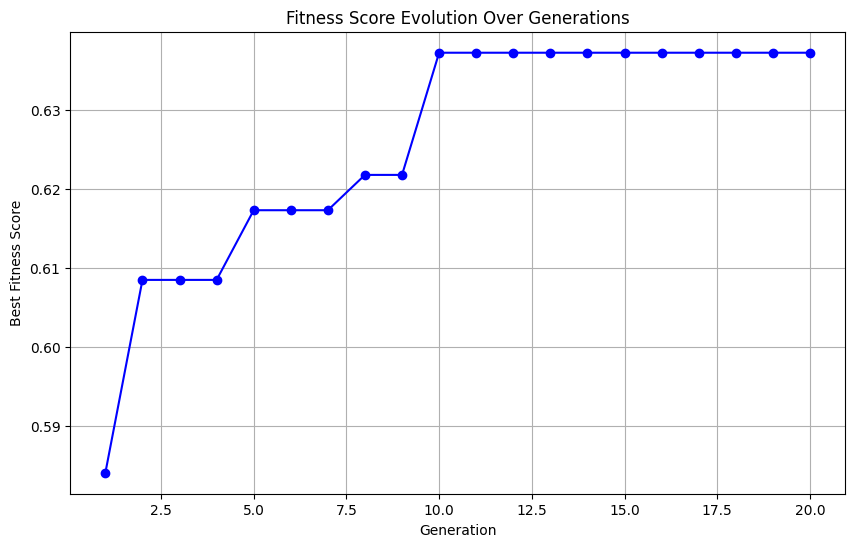

Processing dataset: Multiple Features
Child1:  [1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0.] Using parent1:  [1 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0
 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0
 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 0

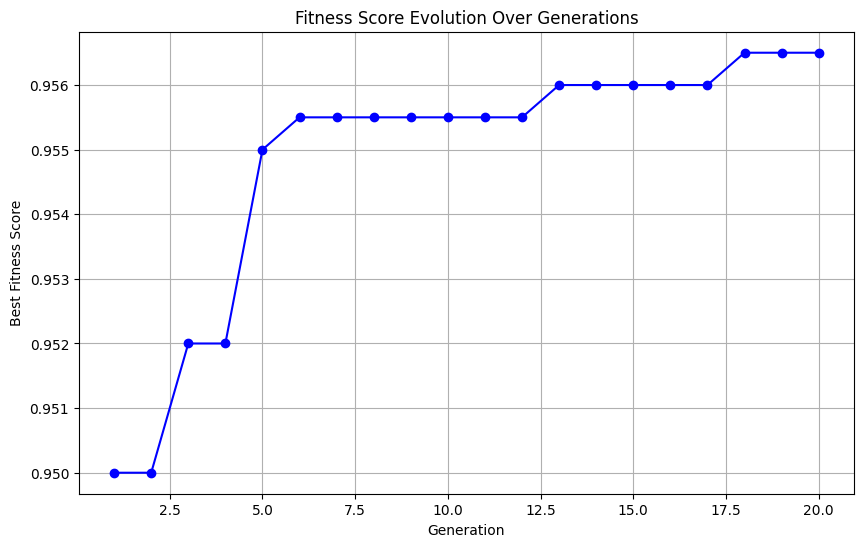

Processing dataset: Australian
Child1:  [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0.] Using parent1:  [0 0 0 0 1 0 0 1 0 0 1 0 1 0]  and parent2:  [1 0 0 0 1 0 0 1 1 1 1 1 0 1]
Child2:  [1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1.]
Child1:  [0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1.] Using parent1:  [0 0 0 1 0 0 0 0 1 1 1 0 1 1]  and parent2:  [0 0 0 1 0 1 1 0 1 0 0 0 0 1]
Child2:  [0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.]
Child1:  [0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1.] Using parent1:  [0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1.]  and parent2:  [0 0 0 0 0 1 1 1 0 0 0 1 0 1]
Child2:  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
Child1:  [0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1.] Using parent1:  [0 0 0 1 0 1 1 0 1 0 0 0 0 1]  and parent2:  [1 0 0 0 1 0 0 1 1 1 1 1 0 1]
Child2:  [1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1.]
Child1:  [1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1.] Using parent1:  [0 0 0 1 0 1 1 0 1 0 0 0 0 1]  and parent2:  [1 0 0 0 1 0 0 1 1 1 1 1 0 1]
Child2:  [0. 0. 0. 1. 1

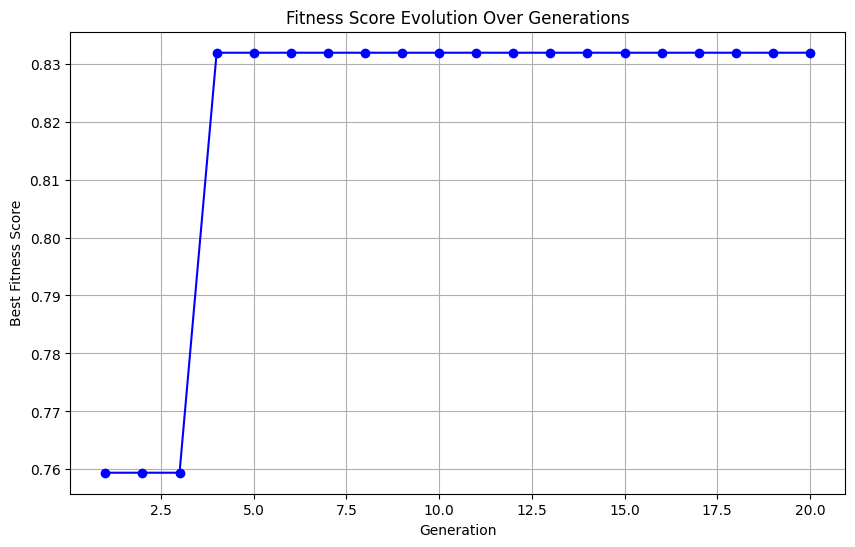

Streaming output truncated to the last 5000 lines.
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 475, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py", line 745, in _asarray_with_order
    ar

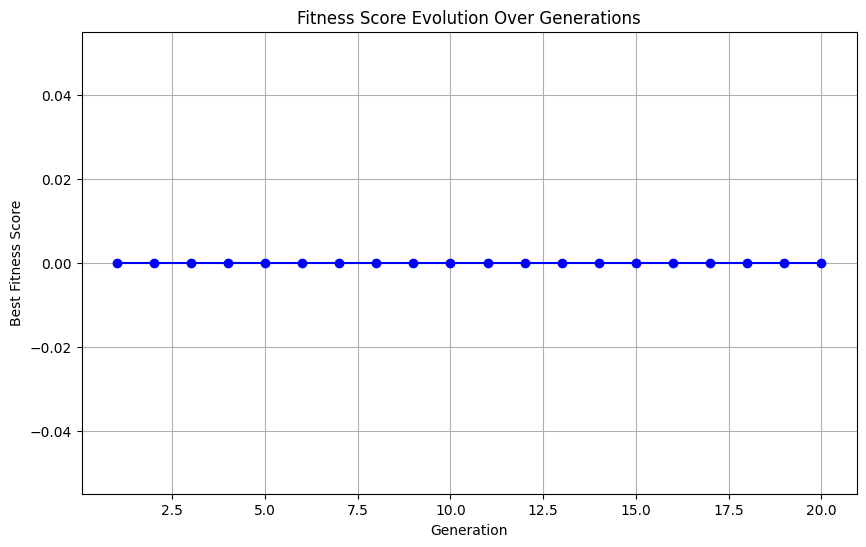

Processing dataset: DNA
Child1:  [1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0.
 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0.
 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.] Using parent1:  [0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 1 1 1 1 1 0
 0 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0
 1 1 1 0 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0
 0 1 0 1 1 0 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0
 1 1 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0]  and parent2:  [1 0 1 0 1 1 1 0 0 0 

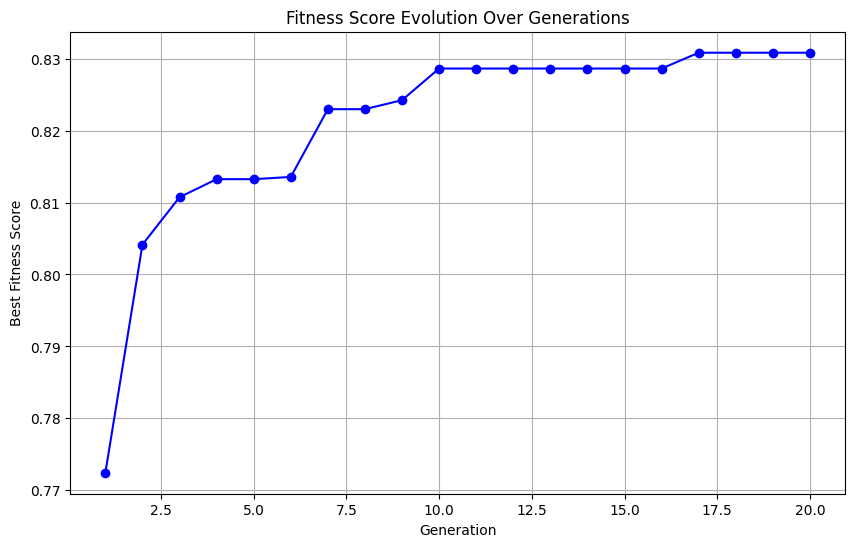

Processing dataset: Wine
Child1:  [0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0.] Using parent1:  [0 0 0 1 0 1 0 0 1 1 0 1 1]  and parent2:  [1 1 1 0 0 1 1 0 0 1 1 0 0]
Child2:  [1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
Child1:  [0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1.] Using parent1:  [1 1 1 0 0 1 1 0 0 1 1 0 0]  and parent2:  [0 0 0 1 0 1 0 0 1 1 0 1 1]
Child2:  [1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.]
Child1:  [1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1.] Using parent1:  [1 1 1 0 0 1 1 0 0 1 1 0 0]  and parent2:  [0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1.]
Child2:  [0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0.]
Child1:  [1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0.] Using parent1:  [1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.]  and parent2:  [1 1 1 0 1 1 1 0 1 0 1 1 0]
Child2:  [1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0.]
Child1:  [1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.] Using parent1:  [1 1 1 0 0 1 1 0 0 1 1 0 0]  and parent2:  [0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0.]
Child2:  [0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0.]
C

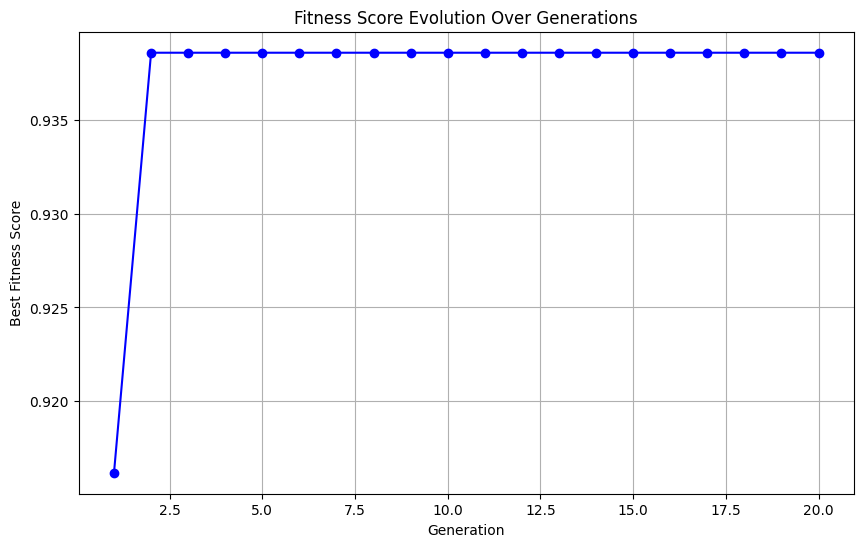

Processing dataset: Vehicle
Child1:  [1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0.] Using parent1:  [0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0]  and parent2:  [1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1]
Child2:  [0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1.]
Child1:  [1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1.] Using parent1:  [1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 0 1 0]  and parent2:  [0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1]
Child2:  [0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.]
Child1:  [1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0.] Using parent1:  [0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.]  and parent2:  [1 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0]
Child2:  [0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
Child1:  [0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.] Using parent1:  [1 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0]  and parent2:  [0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.]
Child2:  [1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0

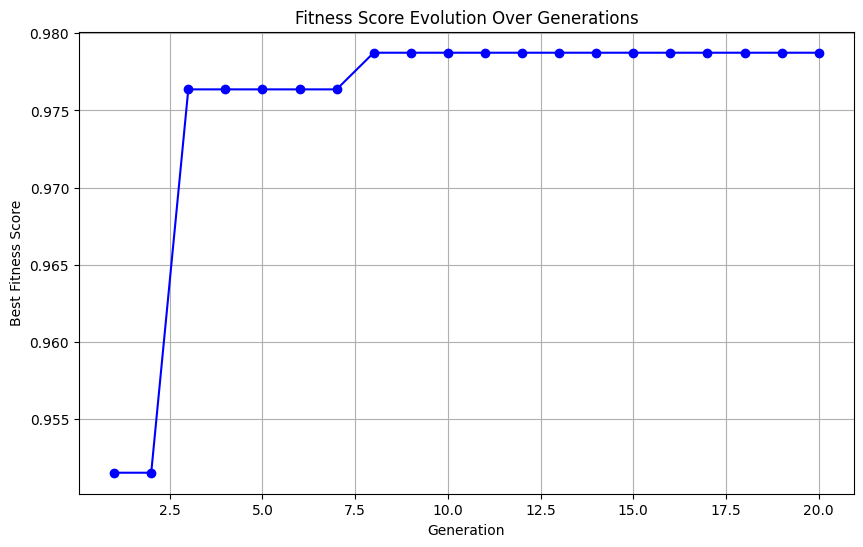

Processing dataset: Waveform
Child1:  [0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0.] Using parent1:  [0 1 1 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0
 1 1 0]  and parent2:  [0 0 1 0 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 1 0 1 0
 0 0 1]
Child2:  [0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1.]
Child1:  [1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0.] Using parent1:  [0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0.]  and parent2:  [1 1 0 0 1 0 1 0 0 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 0
 0 0 0]
Child2:  [0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Child1:  

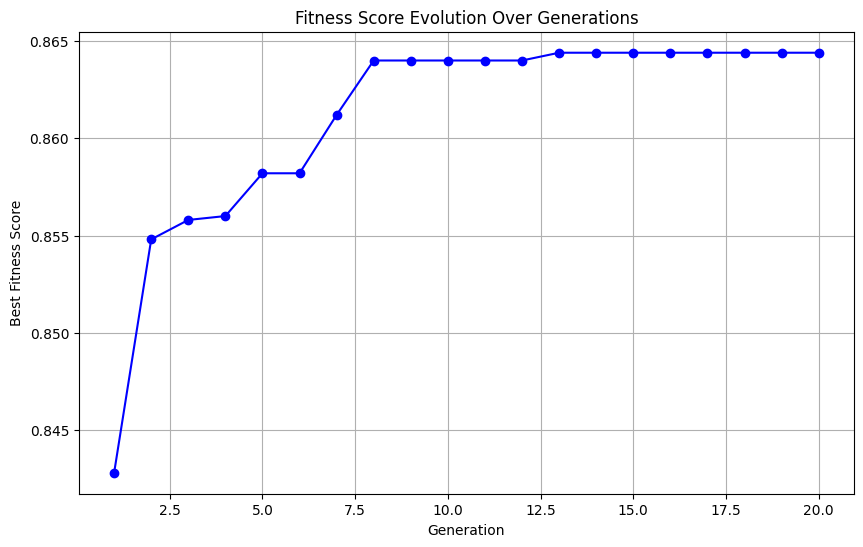

Streaming output truncated to the last 5000 lines.
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py", line 745, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
ValueError: could not convert string to float: 'false'

Error during cross-validation: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **f

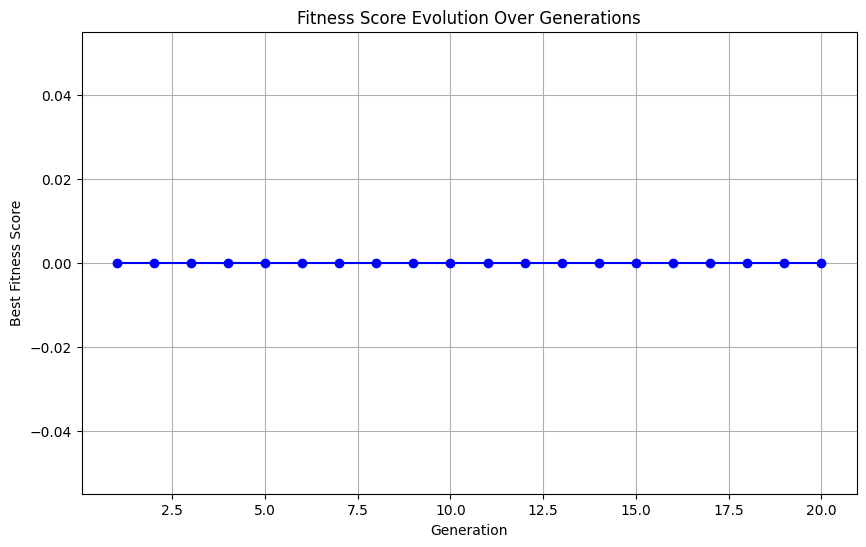

Processing dataset: Hillvalley
Child1:  [1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 0. 1.] Using parent1:  [1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0
 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0
 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 0]  and parent2:  [1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 0 1
 1 0 0 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1
 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1]
Child2:  [1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0.

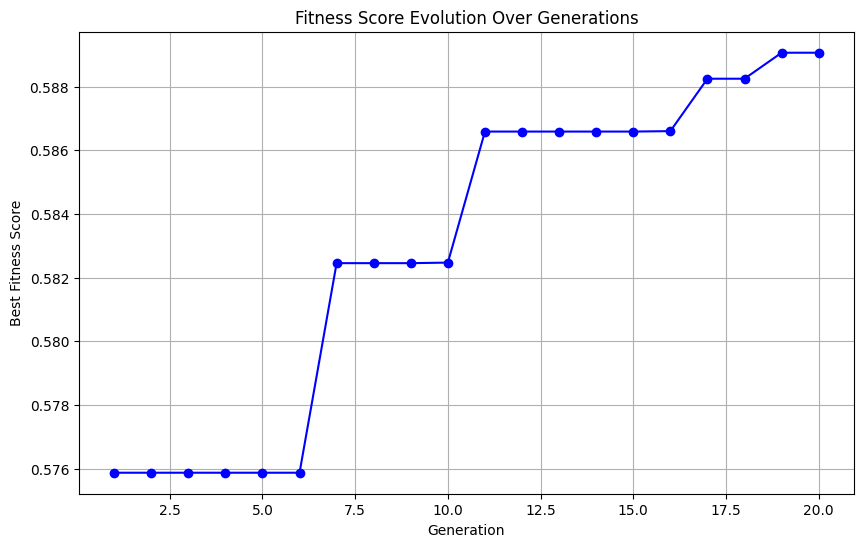

Processing dataset: Sonar
Child1:  [1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1.
 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1.
 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1.] Using parent1:  [0 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1
 0 0 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1]  and parent2:  [1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1
 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1 1 1 0 0 0 1]
Child2:  [0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1.
 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1.
 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1.]
Child1:  [0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1.] Using parent1:  [1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1
 1 0 1 1 0 1 1 1 1 1 0 0 0 

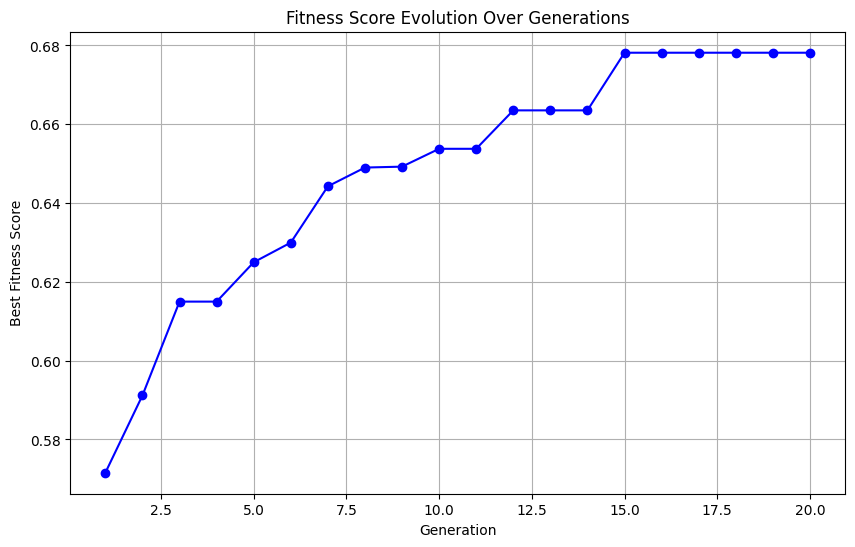

Processing dataset: Musk 1
Error during cross-validation: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 475, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-p

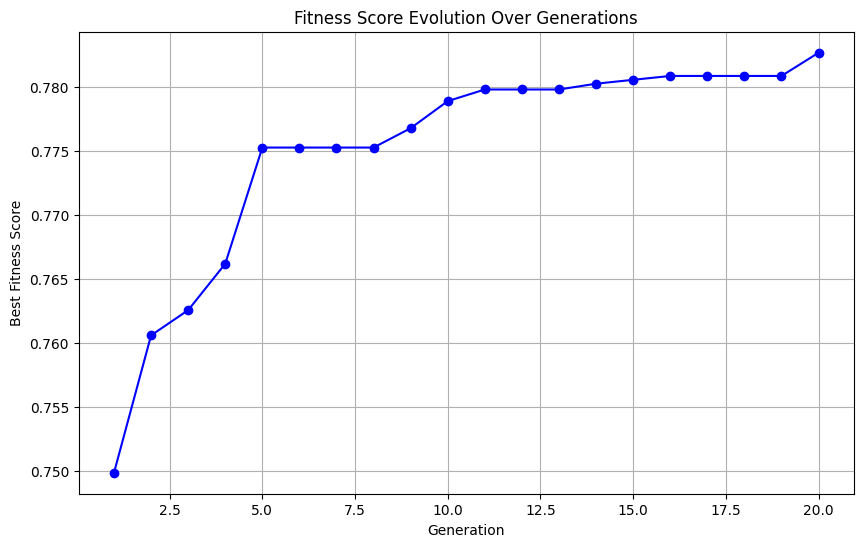

In [23]:
# Define the estimator and cross-validation strategy
estimator = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5)
output_dir = "results"

for dataset_name, dataset_loader in datasets:
    print(f"Processing dataset: {dataset_name}")
    try:
        data = dataset_loader()
        X, y = (data.data, data.target) if hasattr(data, 'data') else (data[0], data[1])

        # Instantiate the SAGAFS_GA class
        ga_fs = SAGAFS_GA(estimator=estimator, cv=cv, scoring='accuracy', population_size=10, generations=20)

        # Fit the model and save results
        best_fitness = ga_fs.fit(X, y, dataset_name=dataset_name, output_dir=output_dir)

        print(f"Best Fitness Score for {dataset_name}: {best_fitness}")
        ga_fs.plot_fitness_over_generations()
    except Exception as e:
        print(f"An error occurred with {dataset_name}: {e}")